In [ ]:
# creating Figure 3 and 4 in paper:

###FIGURE 3 (goes after Figure 4 data):

In [1]:
#Y1 Data

import os, sys
import esutil
import healpy as hp
import numpy as np
%matplotlib inline

%load_ext autoreload
%autoreload 2

sys.path.append('code_py3/')
from cmass_modules import io
from utils import matchCatalogsbyPosition, hpHEALPixelToRaDec, HealPixifyCatalogs, spatialcheck
from xd import mixing_color, XD_fitting_X, assignCMASSProb, doVisualization_1d
from run_DMASS import priorCut_test

In /users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [2]:
#read in gold catalogs here:
##ST82 REGION catalog:

train_path = '/fs/scratch/PCON0003/warner785/bwarner/gold_cat/GOLD_STRIPE82/'
path =  train_path
train_keyword = 'Y1A1_GOLD_STRIPE82_v2'
    
columns = ['FLAGS_GOLD', 'FLAGS_BADREGION', 'MAG_MODEL_G', 'MAG_MODEL_R', 'MAG_MODEL_I', 'MAG_MODEL_Z',\
               'MAG_DETMODEL_G', 'MAG_DETMODEL_R', 'MAG_DETMODEL_I', 'MAG_DETMODEL_Z', 'MAGERR_DETMODEL_G',\
               'MAGERR_DETMODEL_R', 'MAGERR_DETMODEL_I', 'MAGERR_DETMODEL_Z', 'MAGERR_MODEL_G', 'MAGERR_MODEL_R',\
               'MAGERR_MODEL_I', 'MAGERR_MODEL_Z', 'MAG_AUTO_G', 'MAG_AUTO_R', 'MAG_AUTO_I', 'MAG_AUTO_Z', 'RA',\
               'DEC', 'COADD_OBJECTS_ID', 'MODEST_CLASS', 'HPIX', 'DESDM_ZP',\
               'SLR_SHIFT_G', 'SLR_SHIFT_R', 'SLR_SHIFT_I', 'SLR_SHIFT_Z', 'SLR_SHIFT_Y', 'EBV']

gold_st82 = io.SearchAndCallFits(path = train_path, columns = columns, keyword = train_keyword )
gold_st82 = gold_st82[(gold_st82['MODEST_CLASS'] == 1)&(gold_st82['FLAGS_GOLD'] == 0 )]
    
def RemovingSLRReddening(cat):


    if 'SLR_SHIFT_G' not in cat.dtype.names : 
        import numpy.lib.recfunctions as rf   
        #from suchyta_utils.y1a1_slr_shiftmap import SLRShift
        from y1a1_slr_shiftmap import SLRShift
        zpfile = '/fs/scratch/PCON0003/warner785/bwarner/y1a1_wide_slr_wavg_zpshift2.fit'
        slrshift = SLRShift(zpfile, fill_periphery=True)
        offsets_g = slrshift.get_zeropoint_offset('g',cat['RA'],cat['DEC'],interpolate=True)
        offsets_r = slrshift.get_zeropoint_offset('r',cat['RA'],cat['DEC'],interpolate=True)
        offsets_i = slrshift.get_zeropoint_offset('i',cat['RA'],cat['DEC'],interpolate=True)
        offsets_z = slrshift.get_zeropoint_offset('z',cat['RA'],cat['DEC'],interpolate=True)

        offsets = [ offsets_g, offsets_r, offsets_i, offsets_z  ]
        from pandas import DataFrame, concat
        nametag = ['SLR_SHIFT_'+f for f in ['G', 'R', 'I', 'Z'] ]
        catnametag = cat.dtype.names
        try : 
            offsetsdf = DataFrame( offsets, index = nametag ).T
            cat = DataFrame(cat, index = catnametag)
            #del cat['index']
            print('concatenate two ndarrays')
            cat = concat([cat, offsetsdf], axis=1)
            print('dataframe to recordarray')
            cat = cat.to_records()
        
        except ValueError :
            print("Big-endian buffer not supported on little-endian compiler")
            print("Doing byte swapping")
            
            #offsetsdf = np.array(offsetsdf).byteswap().newbyteorder()
            cat = np.array(cat).byteswap().newbyteorder()
            offsetsdf = DataFrame( offsets, index = nametag ).T
            cat = DataFrame(cat)

            print('concatenate two ndarrays')
            cat = concat([cat, offsetsdf], axis=1)
            print('dataframe to recordarray')
            cat = cat.to_records()
            cat.dtype.names = [str(x) for x in cat.dtype.names]
            
            #matched = pd.merge(desData, goldData, on=key, how=how, suffixes = suffixes, left_index=left_index)


    print('Removing SLR Shift ')
    for mag in ['MAG_MODEL', 'MAG_DETMODEL', 'MAG_AUTO']:
        print('  removing SLR from ', mag)
        for b in ['G', 'R', 'I', 'Z']:
            cat[mag + '_'+b] = cat[mag + '_'+b] - cat['SLR_SHIFT'+ '_'+b]

    """
    cat = rf.append_fields(cat, 'SLR_SHIFT_G', offsets_g)
    cat = rf.append_fields(cat, 'SLR_SHIFT_R', offsets_r)
    cat = rf.append_fields(cat, 'SLR_SHIFT_I', offsets_i)
    cat = rf.append_fields(cat, 'SLR_SHIFT_Z', offsets_z)
    """
    return cat

def AddingSFD98Reddening(cat, kind='SPT', coeff = [3.186,2.140,1.569,1.196 ] ):
    import numpy.lib.recfunctions as rf
    import pandas as pd

    band = ['G', 'R', 'I', 'Z']

    if 'EBV' not in cat.dtype.names :   
     
        print('Using SFD98 nside 4096 healpix map')
        print('Bands :',  band)
        #print 'NSIDE = 4096'
        print('coefficients = ', coeff)
        nside = 4096

        #from suchyta_utils.y1a1_slr_shiftmap import SLRShift
        #sfdfile = '/n/des/lee.5922/data/systematic_maps/y1a1_wide_slr_wavg_zpshift2.fit'
        mapname = '/fs/scratch/PCON0003/warner785/bwarner/ebv_sfd98_fullres_nside_4096_nest_equatorial.fits'
        #mapname = '/n/des/lee.5922/data/systematic_maps/ebv_lenz17_nside_4096_nest_equatorial.fits'
        reddening_ring = hp.read_map(mapname)
        hpIndices = np.arange(reddening_ring.size)
        #goodmask = hp.mask_good(reddening_ring)
        #goldmask = 

        goodIndices = hpIndices #hpIndices[goodmask]
        clean_map = reddening_ring #reddening_ring[goodmask]

        sysMap = np.zeros((clean_map.size, ), dtype=[('PIXEL', 'i4'), ('EBV', 'f8'), ('RA', 'f8'), ('DEC', 'f8')])
        sysMap['PIXEL'] = goodIndices
        sysMap['EBV'] = clean_map
        
        sys_ra, sys_dec = hpHEALPixelToRaDec(goodIndices, nside = nside)
        sysMap['RA'] = sys_ra
        sysMap['DEC'] = sys_dec

        from cmass_modules.Cuts import keepGoodRegion
        sysMap = keepGoodRegion(sysMap)
        if kind is 'STRIPE82': sysMap = sysMap[sysMap['DEC'] > -30]
        elif kind is 'SPT': sysMap = sysMap[sysMap['DEC'] < -30]


        cat_hp = cat
        hpind = hpRaDecToHEALPixel(cat_hp['RA'], cat_hp['DEC'], nside= 4096, nest= False)
        #cat_hp.dtype.names = [str(x) for x in cat_hp.dtype.names]
        cat_hp = changeColumnName(cat_hp, name = 'HPIX', rename = 'PIXEL')
        cat_hp['PIXEL'] = hpind
        
        #sfdmap = changeColumnName( sysMap_ge, name = 'SIGNAL', rename = 'SFD98' )


        try : 

            cat_Data = pd.DataFrame(cat_hp)
            sfdData = pd.DataFrame(sysMap)
            matched = pd.merge(cat_Data, sfdData, on='PIXEL', how='left', 
                               suffixes = ['','_sys'], left_index=False, right_index=False)
        except ValueError :
            print("Big-endian buffer not supported on little-endian compiler")
            print("Doing byte swapping ....")

            cat_hp = np.array(cat_hp).byteswap().newbyteorder()
            #sfdmap = np.array(sfdmap).byteswap().newbyteorder()
            cat_Data = pd.DataFrame(cat_hp)
            sfdData = pd.DataFrame(sysMap)
            

            #print cat_Data.keys()
            #print sfdData.keys()
            matched = pd.merge(cat_Data, sfdData, on='PIXEL', how='left', 
                               suffixes = ['','_sys'], left_index=False, right_index=False)
            
        matched_arr = matched.to_records(index=False)
        matched_arr.dtype.names = [str(x) for x in matched_arr.dtype.names]


    else : matched_arr = cat

    print('Adding SFD98 Shift ')
    print('Bands :',  band)
    print('coefficients = ', coeff)

    for mag in ['MAG_MODEL', 'MAG_DETMODEL', 'MAG_AUTO']:
        print('  Adding SFD to ', mag)
        for i,b in enumerate(band):
            matched_arr[mag + '_'+b] = matched_arr[mag + '_'+b] - matched_arr['EBV'] * coeff[i]    

    return matched_arr

params={'SFD98':True}
if 'SFD98' in params : 
    if params['SFD98'] : 
        print('change reddening corrections from SLR to SFD98')
        gold_st82 = RemovingSLRReddening(gold_st82)
        gold_st82 = AddingSFD98Reddening(gold_st82, kind='STRIPE82')

# flags and color cut
mask_all = priorCut_test(gold_st82)
gold_st82 = gold_st82[mask_all]
print(gold_st82.size)


Calling catalogs >>>
Y1A1_GOLD_STRIPE82_v2_000006.fits
Y1A1_GOLD_STRIPE82_v2_000005.fits
Y1A1_GOLD_STRIPE82_v2_000002.fits
Y1A1_GOLD_STRIPE82_v2_000008.fits
Y1A1_GOLD_STRIPE82_v2_000003.fits
Y1A1_GOLD_STRIPE82_v2_000001.fits
Y1A1_GOLD_STRIPE82_v2_000007.fits
Y1A1_GOLD_STRIPE82_v2_000004.fits
reading 1/8 /fs/scratch/PCON0003/warner785/bwarner/gold_cat/GOLD_STRIPE82/Y1A1_GOLD_STRIPE82_v2_000006.fits
reading 2/8 /fs/scratch/PCON0003/warner785/bwarner/gold_cat/GOLD_STRIPE82/Y1A1_GOLD_STRIPE82_v2_000005.fits
reading 3/8 /fs/scratch/PCON0003/warner785/bwarner/gold_cat/GOLD_STRIPE82/Y1A1_GOLD_STRIPE82_v2_000002.fits
reading 4/8 /fs/scratch/PCON0003/warner785/bwarner/gold_cat/GOLD_STRIPE82/Y1A1_GOLD_STRIPE82_v2_000008.fits
reading 5/8 /fs/scratch/PCON0003/warner785/bwarner/gold_cat/GOLD_STRIPE82/Y1A1_GOLD_STRIPE82_v2_000003.fits
reading 6/8 /fs/scratch/PCON0003/warner785/bwarner/gold_cat/GOLD_STRIPE82/Y1A1_GOLD_STRIPE82_v2_000001.fits
reading 7/8 /fs/scratch/PCON0003/warner785/bwarner/gold_ca

In [3]:
##SPT REGION catalog:

# Calling Y1 GOLD in a small square area 
input_path = '/fs/scratch/PCON0003/warner785/bwarner/gold_cat/'
input_keyword = 'Y1A1_GOLD_slr_ebv_'
columns = ['FLAGS_GOLD', 'FLAGS_BADREGION', 'MAG_MODEL_G', 'MAG_MODEL_R', 'MAG_MODEL_I', 'MAG_MODEL_Z',\
               'MAG_DETMODEL_G', 'MAG_DETMODEL_R', 'MAG_DETMODEL_I', 'MAG_DETMODEL_Z', 'MAGERR_DETMODEL_G',\
               'MAGERR_DETMODEL_R', 'MAGERR_DETMODEL_I', 'MAGERR_DETMODEL_Z', 'MAGERR_MODEL_G', 'MAGERR_MODEL_R',\
               'MAGERR_MODEL_I', 'MAGERR_MODEL_Z', 'MAG_AUTO_G', 'MAG_AUTO_R', 'MAG_AUTO_I', 'MAG_AUTO_Z', 'RA',\
               'DEC', 'COADD_OBJECTS_ID', 'MODEST_CLASS', 'HPIX', 'DESDM_ZP',\
               'SLR_SHIFT_G','SLR_SHIFT_R', 'SLR_SHIFT_I', 'SLR_SHIFT_Z','EBV']
gold_spt = io.SearchAndCallFits(path = input_path, keyword = input_keyword, columns=columns)
gold_spt = gold_spt[(gold_spt['MODEST_CLASS'] == 1)&(gold_spt['FLAGS_GOLD'] == 0 )]

#correct for SFD98:
params={'SFD98':True}
if 'SFD98' in params : 
    if params['SFD98'] : 
        print('change reddening corrections from SLR to SFD98')
        gold_spt = RemovingSLRReddening(gold_spt)
        gold_spt = AddingSFD98Reddening(gold_spt, kind='SPT')
        
# Apply the same color/mag cuts to exclude extreme color/mag sources //
mask_magcut = priorCut_test(gold_spt)
gold_spt = gold_spt[mask_magcut]
        
print(gold_spt.size)


Calling catalogs >>>
Y1A1_GOLD_slr_ebv_000007.fits
Y1A1_GOLD_slr_ebv_000015.fits
Y1A1_GOLD_slr_ebv_000008.fits
Y1A1_GOLD_slr_ebv_000010.fits
Y1A1_GOLD_slr_ebv_000009.fits
Y1A1_GOLD_slr_ebv_000014.fits
Y1A1_GOLD_slr_ebv_000003.fits
Y1A1_GOLD_slr_ebv_000011.fits
Y1A1_GOLD_slr_ebv_000004.fits
Y1A1_GOLD_slr_ebv_000012.fits
Y1A1_GOLD_slr_ebv_000005.fits
Y1A1_GOLD_slr_ebv_000013.fits
Y1A1_GOLD_slr_ebv_000001.fits
Y1A1_GOLD_slr_ebv_000006.fits
Y1A1_GOLD_slr_ebv_000002.fits
reading 1/15 /fs/scratch/PCON0003/warner785/bwarner/gold_cat/Y1A1_GOLD_slr_ebv_000007.fits
reading 2/15 /fs/scratch/PCON0003/warner785/bwarner/gold_cat/Y1A1_GOLD_slr_ebv_000015.fits
reading 3/15 /fs/scratch/PCON0003/warner785/bwarner/gold_cat/Y1A1_GOLD_slr_ebv_000008.fits
reading 4/15 /fs/scratch/PCON0003/warner785/bwarner/gold_cat/Y1A1_GOLD_slr_ebv_000010.fits
reading 5/15 /fs/scratch/PCON0003/warner785/bwarner/gold_cat/Y1A1_GOLD_slr_ebv_000009.fits
reading 6/15 /fs/scratch/PCON0003/warner785/bwarner/gold_cat/Y1A1_GOLD_sl

In [4]:
# other catalog for spt in directory: (for check)

##SPT REGION catalog:

# Calling Y1 GOLD in a small square area 
input_path = '/fs/scratch/PCON0003/warner785/bwarner/gold_cat/GOLD_Y1A1/'
input_keyword = 'Y1A1'
columns = ['FLAGS_GOLD', 'FLAGS_BADREGION', 'MAG_MODEL_G', 'MAG_MODEL_R', 'MAG_MODEL_I', 'MAG_MODEL_Z',\
               'MAG_DETMODEL_G', 'MAG_DETMODEL_R', 'MAG_DETMODEL_I', 'MAG_DETMODEL_Z', 'MAGERR_DETMODEL_G',\
               'MAGERR_DETMODEL_R', 'MAGERR_DETMODEL_I', 'MAGERR_DETMODEL_Z', 'MAGERR_MODEL_G', 'MAGERR_MODEL_R',\
               'MAGERR_MODEL_I', 'MAGERR_MODEL_Z', 'MAG_AUTO_G', 'MAG_AUTO_R', 'MAG_AUTO_I', 'MAG_AUTO_Z', 'RA',\
               'DEC', 'COADD_OBJECTS_ID', 'MODEST_CLASS', 'HPIX', 'DESDM_ZP']
gold_spt2 = io.SearchAndCallFits(path = input_path, keyword = input_keyword, columns=columns)
gold_spt2 = gold_spt2[(gold_spt2['MODEST_CLASS'] == 1)&(gold_spt2['FLAGS_GOLD'] == 0 )]

"""#correct for SFD98:
params={'SFD98':True}
if 'SFD98' in params : 
    if params['SFD98'] : 
        print('change reddening corrections from SLR to SFD98')
        gold_spt2 = RemovingSLRReddening(gold_spt2)
        gold_spt2 = AddingSFD98Reddening(gold_spt2, kind='SPT')"""
        
# Apply the same color/mag cuts to exclude extreme color/mag sources //
mask_magcut = priorCut_test(gold_spt2)
gold_spt2 = gold_spt2[mask_magcut]
        
print(gold_spt2.size)

#cuts could be different to begin with


Calling catalogs >>>
Y1A1_GOLD_000007.fits
Y1A1_GOLD_000002.fits
Y1A1_GOLD_000008.fits
Y1A1_GOLD_000006.fits
Y1A1_GOLD_000013.fits
Y1A1_GOLD_000015.fits
Y1A1_GOLD_000011.fits
Y1A1_GOLD_000004.fits
Y1A1_GOLD_000010.fits
Y1A1_GOLD_000009.fits
Y1A1_GOLD_000012.fits
Y1A1_GOLD_000014.fits
Y1A1_GOLD_000003.fits
Y1A1_GOLD_000001.fits
Y1A1_GOLD_000005.fits
reading 1/15 /fs/scratch/PCON0003/warner785/bwarner/gold_cat/GOLD_Y1A1/Y1A1_GOLD_000007.fits
reading 2/15 /fs/scratch/PCON0003/warner785/bwarner/gold_cat/GOLD_Y1A1/Y1A1_GOLD_000002.fits
reading 3/15 /fs/scratch/PCON0003/warner785/bwarner/gold_cat/GOLD_Y1A1/Y1A1_GOLD_000008.fits
reading 4/15 /fs/scratch/PCON0003/warner785/bwarner/gold_cat/GOLD_Y1A1/Y1A1_GOLD_000006.fits
reading 5/15 /fs/scratch/PCON0003/warner785/bwarner/gold_cat/GOLD_Y1A1/Y1A1_GOLD_000013.fits
reading 6/15 /fs/scratch/PCON0003/warner785/bwarner/gold_cat/GOLD_Y1A1/Y1A1_GOLD_000015.fits
reading 7/15 /fs/scratch/PCON0003/warner785/bwarner/gold_cat/GOLD_Y1A1/Y1A1_GOLD_000011.fi

In [ ]:
#checking the magnitude cuts between the two sections:
print(gold_spt['MAG_DETMODEL_R'])

In [27]:
print(gold_st82['MAG_DETMODEL_R'])

#these appear to have been applied correctly

[21.23384  20.250126 21.090021 ... 18.908398 21.241213 21.020706]


In [5]:
#takes 1 percent of spt sample:
print(gold_spt.size)
gold_spt_random_ind = np.random.choice(np.arange(gold_spt.size), size = int(gold_spt.size/100))
gold_spt_random = gold_spt[gold_spt_random_ind]
print(gold_spt_random.size)

7015838
70158


In [6]:
#implement Cuts.keepgoodregion:

def keepGoodRegion(des, hpInd = False, balrog=None):
    import healpy as hp
    import fitsio
    # 25 is the faintest object detected by DES
    # objects larger than 25 considered as Noise
    
    path = '/fs/scratch/PCON0003/warner785/bwarner/'
    #LSSGoldmask = fitsio.read(path+'Y1LSSmask_v2_il22_seeil4.0_nside4096ring_redlimcut.fits')
    #LSSGoldmask = fitsio.read(path+'Y1LSSmask_v1_il22seeil4.04096ring_redlimcut.fits')
    LSSGoldmask = fitsio.read(path+'Y1LSSmask_v2_redlimcut_il22_seeil4.0_4096ring.fits')
    #Y1LSSmask_v1_il22seeil4.04096ring_redlimcut.fits
    #frac_cut = LSSGoldmask['FRAC'] > 0.8
    #ind_good_ring = LSSGoldmask['PIXEL'][frac_cut]
    ind_good_ring = LSSGoldmask['PIXEL']
    
    # healpixify the catalog.
    nside=4096
    # Convert silly ra/dec to silly HP angular coordinates.
    phi = des['RA'] * np.pi / 180.0
    theta = ( 90.0 - des['DEC'] ) * np.pi/180.0

    hpInd = hp.ang2pix(nside,theta,phi,nest=False)
    keep = np.in1d(hpInd, ind_good_ring)
    des = des[keep]
    if hpInd is True:
        return ind_good_ring
    else:
        return des
    
gold_st82 = keepGoodRegion(gold_st82)
print(gold_st82.size)
gold_spt = keepGoodRegion(gold_spt)
print(gold_spt.size)

694475
7015838


In [7]:
# compare GOLD catalog in ST82 and SPT

print(gold_st82.size)
print(gold_spt_random.size)

#des gold catalog probability distribution

X_train, Xcov_train = mixing_color(gold_st82)
X_sample_st82 = X_train
X_train2, Xcov_train2 = mixing_color(gold_spt_random)
X_sample_spt = X_train2

# Comparison. st82 vs. spt sample from the fitted gaussian mixture model (visual)
# des gold galaxies: should be same because isotropic-- color cuts problem?
doVisualization_1d( data=[X_sample_st82, X_sample_spt], 
                   labels = ['mag r', 'mag i', 'g-r', 'r-i'], 
                   ranges = None, 
                   name = ['st82', 'spt'], 
                   weight = [None,None], 
                   nbins=100, filename = 'ST82vSPT.png')

694475
70158
Using central 100% to set range.


17719345
17719345
Using central 100% to set range.


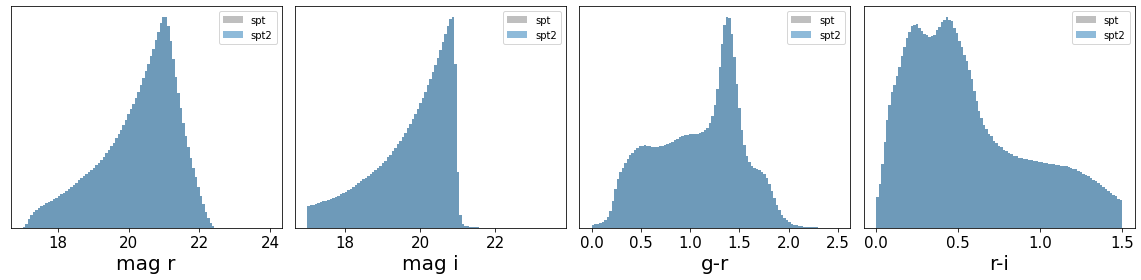

In [19]:
# compare different SPT fits files

print(gold_spt.size)
print(gold_spt2.size)

#des gold catalog probability distribution

X_train, Xcov_train = mixing_color(gold_spt)
X_sample_spt = X_train
X_train2, Xcov_train2 = mixing_color(gold_spt2)
X_sample_spt2 = X_train2

# Comparison. st82 vs. spt sample from the fitted gaussian mixture model (visual)
# des gold galaxies: should be same because isotropic-- color cuts problem?
doVisualization_1d( data=[X_sample_spt, X_sample_spt2], 
                   labels = ['mag r', 'mag i', 'g-r', 'r-i'], 
                   ranges = None, 
                   name = ['spt', 'spt2'], 
                   weight = [None,None],
                   nbins=100)

#these match

In [7]:
#cmass catalog

import fitsio
cmass = esutil.io.read('/fs/scratch/PCON0003/warner785/bwarner/cmass-dr12v4-S-Reid-full.dat.fits')
train_sample = esutil.io.read('/fs/scratch/PCON0003/warner785/bwarner/cmass-dr12v4-S-Reid-full.dat.fits')
#train_sample = esutil.io.read('/global/cscratch1/sd/bwarner/galaxy_DR11v1_CMASS_South-photoObj.fits.gz')
print('total num of train', train_sample.size)
print('\n--------------------------------\n applying DES veto mask to CMASS\n--------------------------------')   
train_sample = keepGoodRegion(train_sample)

#fitsio.write( output_dir+'/cmass_in_st82.fits', train_sample)

print('num of train_sample after des veto', train_sample.size)

#matching:
# find cmass in des_gold side --------------------

mg1, mg2, _ = esutil.htm.HTM(10).match(train_sample['RA'], train_sample['DEC'], gold_st82['RA'], \
                                         gold_st82['DEC'],2./3600, maxmatch=1)
cmass_mask = np.zeros(gold_st82.size, dtype=bool)
cmass_mask[mg2] = 1
clean_cmass_data_des, nocmass = gold_st82[cmass_mask], gold_st82[~cmass_mask]

print(nocmass.size)

print(('num of cmass in des side', clean_cmass_data_des.size, '({:0.0f}%)'.format(clean_cmass_data_des.size*1./cmass.size*100.)))

total num of train 258884

--------------------------------
 applying DES veto mask to CMASS
--------------------------------
num of train_sample after des veto 13046
681836
('num of cmass in des side', 12639, '(5%)')


In [8]:
###FIGURE 4:

clf_cmass = XD_fitting_X( None, None, pickleFileName = '../output/test/fitting/gauss_cmass_v4.pkl')               
clf_no = XD_fitting_X( None, None, pickleFileName = '../output/test/fitting/gauss_no_v4.pkl')

cmass_fraction = clean_cmass_data_des.size *1./gold_st82.size
#call in catalogs
# Assigning CMASS probabilities to Gold Y1 in Stripe 82.
mag = ['MAG_MODEL', 'MAG_DETMODEL'] 
err = ['MAGERR_MODEL', 'MAGERR_DETMODEL'] 
filter = ['G', 'R', 'I']

mask_half = gold_st82['RA'] < 320
gold_st82_train = gold_st82[mask_half] #-- y1: gold_st82
gold_st82_test = gold_st82[~mask_half] #-- y1: gold_spt (same method)

mask_half = clean_cmass_data_des['RA'] < 320
cmass_train = clean_cmass_data_des[mask_half]
cmass_test = clean_cmass_data_des[~mask_half]


clean_dmass_prob = assignCMASSProb(clean_cmass_data_des, clf_cmass, clf_no, 
                     cmass_fraction =cmass_fraction
, 
                     mag=mag, err=err, filter=filter ) 
#dmass_st82 = io.SearchAndCallFits(path = rootdir, keyword='gold_st82_prob.fits')
#this is simply gold_st82 with all cuts made
#XD of y1 gold des in st82 -- with membership probability
dmass_st82 = clean_dmass_prob # actual CMASS gal in val set

gold_st82_val = assignCMASSProb(gold_st82, clf_cmass, clf_no, 
                     cmass_fraction = cmass_fraction
, 
                     mag=mag, err=err, filter=filter )

# Assigning CMASS probabilities to Gold Y1 in SPT.
mag = ['MAG_MODEL', 'MAG_DETMODEL'] 
err = ['MAGERR_MODEL', 'MAGERR_DETMODEL'] 
filter = ['G', 'R', 'I']
gold_spt_test = assignCMASSProb(gold_spt_random, clf_cmass, clf_no, 
                     cmass_fraction = cmass_fraction
, 
                     mag=mag, err=err, filter=filter )
#dmass_spt = io.SearchAndCallFits(path = rootdir, keyword='dmass_spt_sys_v3.fits')
#gold_spt data
#XD of y1 gold des in spt -- with membership probability
dmass_spt = gold_spt_test

print(cmass_fraction)

calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 
calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 
0.01819935922819396


In [9]:
# for Figure 3


clf_cmass = XD_fitting_X( None, None, pickleFileName = '../output/test/fitting/gauss_cmass_v4.pkl')               
clf_no = XD_fitting_X( None, None, pickleFileName = '../output/test/fitting/gauss_no_v4.pkl')

cmass_fraction = clean_cmass_data_des.size *1./gold_st82.size
#call in catalogs
# Assigning CMASS probabilities to Gold Y1 in Stripe 82.
mag = ['MAG_MODEL', 'MAG_DETMODEL'] 
err = ['MAGERR_MODEL', 'MAGERR_DETMODEL'] 
filter = ['G', 'R', 'I']

mask_half = gold_st82['RA'] < 320
gold_st82_train = gold_st82[mask_half] #-- y1: gold_st82
gold_st82_test = gold_st82[~mask_half] #-- y1: gold_spt (same method)

mask_half = clean_cmass_data_des['RA'] < 320
cmass_train = clean_cmass_data_des[mask_half]
cmass_test = clean_cmass_data_des[~mask_half]


clean_dmass_prob = assignCMASSProb(cmass_test, clf_cmass, clf_no, 
                     cmass_fraction =cmass_fraction
, 
                     mag=mag, err=err, filter=filter ) 
#dmass_st82 = io.SearchAndCallFits(path = rootdir, keyword='gold_st82_prob.fits')
#this is simply gold_st82 with all cuts made
#XD of y1 gold des in st82 -- with membership probability
dmass_st82 = clean_dmass_prob # actual CMASS gal in val set

gold_st82_val = assignCMASSProb(gold_st82_test, clf_cmass, clf_no, 
                     cmass_fraction = cmass_fraction
, 
                     mag=mag, err=err, filter=filter )

# Assigning CMASS probabilities to Gold Y1 in SPT.
mag = ['MAG_MODEL', 'MAG_DETMODEL'] 
err = ['MAGERR_MODEL', 'MAGERR_DETMODEL'] 
filter = ['G', 'R', 'I']
gold_spt_test = assignCMASSProb(gold_spt_random, clf_cmass, clf_no, 
                     cmass_fraction = cmass_fraction
, 
                     mag=mag, err=err, filter=filter )
#dmass_spt = io.SearchAndCallFits(path = rootdir, keyword='dmass_spt_sys_v3.fits')
#gold_spt data
#XD of y1 gold des in spt -- with membership probability
dmass_spt = gold_spt_test

print(cmass_fraction)

calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 
calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 
calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 
0.01819935922819396


In [19]:
#dmass_st82['CMASS_PROB'].min()
#N, _ = np.histogram(dmass_st82['CMASS_PROB'], bins=pbin)

fig, ax = plt.subplots()
ax.hist(dmass_st82['CMASS_PROB'])
fig.savefig('histogram.png')

In [27]:
print(dmass_spt.dtype.names)
print(clean_cmass_data_des.dtype.names)

('FLAGS_GOLD', 'FLAGS_BADREGION', 'MAG_MODEL_G', 'MAG_MODEL_R', 'MAG_MODEL_I', 'MAG_MODEL_Z', 'MAG_DETMODEL_G', 'MAG_DETMODEL_R', 'MAG_DETMODEL_I', 'MAG_DETMODEL_Z', 'MAGERR_DETMODEL_G', 'MAGERR_DETMODEL_R', 'MAGERR_DETMODEL_I', 'MAGERR_DETMODEL_Z', 'MAGERR_MODEL_G', 'MAGERR_MODEL_R', 'MAGERR_MODEL_I', 'MAGERR_MODEL_Z', 'MAG_AUTO_G', 'MAG_AUTO_R', 'MAG_AUTO_I', 'MAG_AUTO_Z', 'RA', 'DEC', 'COADD_OBJECTS_ID', 'MODEST_CLASS', 'HPIX', 'DESDM_ZP', 'EBV', 'CMASS_PROB')
('COADD_OBJECTS_ID', 'RA', 'DEC', 'EBV', 'MAG_AUTO_G', 'MAG_AUTO_I', 'MAG_AUTO_R', 'MAG_AUTO_Z', 'MAG_MODEL_G', 'MAG_MODEL_I', 'MAG_MODEL_R', 'MAG_MODEL_Z', 'MAG_DETMODEL_G', 'MAG_DETMODEL_I', 'MAG_DETMODEL_R', 'MAG_DETMODEL_Z', 'MAGERR_MODEL_G', 'MAGERR_MODEL_R', 'MAGERR_MODEL_I', 'MAGERR_MODEL_Z', 'MAGERR_DETMODEL_G', 'MAGERR_DETMODEL_R', 'MAGERR_DETMODEL_I', 'MAGERR_DETMODEL_Z', 'SLR_SHIFT_G', 'SLR_SHIFT_R', 'SLR_SHIFT_I', 'SLR_SHIFT_Z', 'SLR_SHIFT_Y', 'FLAGS_BADREGION', 'FLAGS_GOLD', 'DESDM_ZP', 'MODEST_CLASS', 'HPIX')


0 14.265369095656302
1 8.96431679721497
2 7.769602025476699
3 7.611361658359048
4 7.010048263311972
5 8.157290924914946
6 8.418387530659071
7 9.874198908141468
8 12.11330010285624
9 15.81612469340929


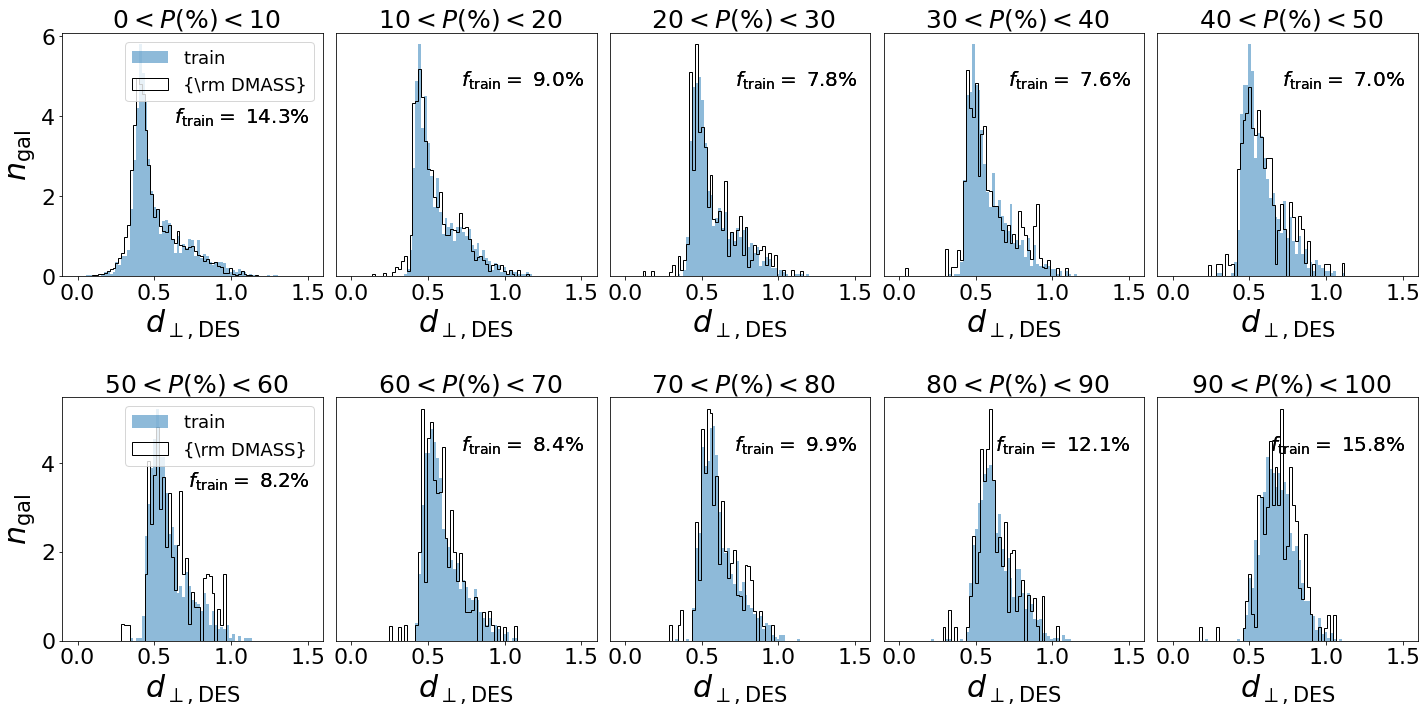

In [8]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
%matplotlib inline

probcut = 0.0
np.linspace(0.0, 1.5, 6)

labels = [r'${\rm train}$', r'{\rm DMASS}']
catlist = [dmass_st82, dmass_spt[dmass_spt['CMASS_PROB']>0.00]]
cbin = np.linspace(0.,1.5, 80)
probcut = 0
fig, ax = plt.subplots(2,5, figsize=(20,10))
ax = ax.ravel()

for i in range(10):     
    for la, cat in zip(labels, catlist) :     
        mask = (cat['CMASS_PROB'] > probcut) & (cat['CMASS_PROB'] < probcut + 0.1) \
        & (cat['CMASS_PROB'] > 0.00) # & ( (cat['MAG_MODEL_G']- cat['MAG_MODEL_R']) < 1.6)
        
        histtype = 'stepfilled'
        alpha = 0.5
        if la == r'{\rm DMASS}' : 
            Nhist, _,_ = ax[i].hist( (cat['MAG_DETMODEL_R']-cat['MAG_DETMODEL_I']- (cat['MAG_DETMODEL_G']-cat['MAG_DETMODEL_R'])/8.)[mask], \
                    bins = cbin, density= True, alpha = 1.0, label = la + ''.format(np.sum(mask)*1./mask.size*100), \
                       histtype='step', color = 'black', weights = cat[mask]['CMASS_PROB']);  
        
        else : 
            Nhist2, _, _=ax[i].hist( (cat['MAG_DETMODEL_R']-cat['MAG_DETMODEL_I']- (cat['MAG_DETMODEL_G']-cat['MAG_DETMODEL_R'])/8.)[mask], \
                    bins = cbin, density = True, alpha = alpha, label = la + ''.format(np.sum(mask)*1./mask.size*100), \
                     histtype=histtype); 
            fraction_train = np.sum(mask)*1./mask.size*100
            print(i, fraction_train)
            
        #print probcut, probcut+0.1, np.sum(mask), la
        #print i,
        tag = r' ${:0.0f} < P(\%) < {:0.0f}$'.format(probcut*100, probcut*100+10)
        
        #ax[i].set_xlim(0, 1.0)
        if i in [0, 5]: 
            ax[i].legend(loc=1, fontsize = 18)
            ax[i].set_ylabel(r'$n_{\rm gal}$', fontsize = 30)
            
#            ax[i].set_yticks([0, max(Nhist.max(), Nhist2.max())])
#            ax[i].set_yticklabels(['$0$', '$1$'])
            ax[i].text(0.95, 0.7, r'$f_{\rm train}=$'+'$~{:0.1f}\%$'.format(fraction_train), 
                   fontsize = 20, ha='right', va='top', transform=ax[i].transAxes)
        else : 
            #pass
            ax[i].get_yaxis().set_visible(False)
            ax[i].text(0.95, 0.85, r'$f_{\rm train}=$'+'$~{:0.1f}\%$'.format(fraction_train), 
                   fontsize = 20, ha='right', va='top', transform=ax[i].transAxes)
        ax[i].set_title(tag, fontsize=25)
        ax[i].set_xlabel(r'$d_{\perp, {\rm DES}}$', fontsize = 30)
        ax[i].set_xlim(-0.1, 1.6)
        ax[i].set_xticks(np.linspace(0.0, 1.5, 4))
        #ax[i].set_xticklabels(np.linspace(0.0, 1.5, 6))
        #ax[i].set_ylabel(r'$n(z)$')
        #ax[i].get_yaxis().set_visible(False)
        ax[i].tick_params(labelsize = 22)
        #ax[i].set_ylim(0,7)
        
        #ax[i].xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        #elif i != 2 : ax[i].get_yaxis().set_visible(False)
        
    probcut += 0.1
    
#ax[0].get_yaxis().set_visible(True)
#ax[5].get_yaxis().set_visible(True)


fig.tight_layout()
fig.subplots_adjust(wspace=0.05, hspace=0.5);

In [28]:
# FIGURE 3
pbin = np.linspace(0, 1, 21)
pcenter = pbin[:-1] + 0.025
N, _ = np.histogram(dmass_st82['CMASS_PROB'], bins=pbin)
print('pbin =', pbin)
import matplotlib.pyplot as plt
#pbin, frac, fracerr = np.genfromtxt('../paper_figure/model_probability.txt', unpack=True)

M, _ = np.histogram(gold_st82_val['CMASS_PROB'], bins=pbin)

frac = N/M
print('frac = ', frac)
fracerr = 1/np.sqrt(N) #1 / sqrt(number of true cmass galaxies in each bin)

fig, ax = plt.subplots()
ax.errorbar( pcenter, frac, yerr=fracerr)
ax.plot([0,1], [0,1], ls='--', color='grey')

fig.savefig('test_histo.pdf')

stop

print(N.size)
print(pbin.size)

fig, ax = plt.subplots(figsize = (5.3,5))

ax.bar(pcenter, frac , 5, edgecolor='w',
        color='grey', yerr = fracerr, 
        alpha = 0.5, label = 'test', error_kw = {'elinewidth':0.01, 'capsize':2.4} )

ax.plot([0,1], [0,1], ls='--', color='grey')
ax.set_ylim(0,1)
ax.set_xlim(0,1)

ax.set_xlabel(r'{\rm Model Probability (\%)}', fontsize = 20)
ax.set_ylabel(r'$f_{ {\rm CMASS},~i}~(\%)$', fontsize = 20)
ax.tick_params(axis='both', labelsize = 15)
#ax.legend(loc='best', fontsize=15)
fig.tight_layout()
fig.savefig('model_probability.pdf')

pbin = [0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ]
frac =  [0.00170232 0.06225026 0.10803746 0.16193481 0.19897484 0.25261217
 0.30786517 0.33226066 0.37512953 0.4556213  0.51576577 0.55112219
 0.60027285 0.6743555  0.70555556 0.74005305 0.79333333 0.83503982
 0.86881473 0.9093432 ]


NameError: name 'stop' is not defined

In [ ]:
pbin, frac, fracerr = np.genfromtxt('../paper_figure/model_probability.txt', unpack=True)


fig, ax = plt.subplots(figsize = (5.3,5))

ax.bar(pbin, frac , 5, edgecolor='w',
        color='grey', yerr = fracerr, 
        alpha = 0.5, label = 'test', error_kw = {'elinewidth':1, 'capsize':2.4} )

ax.plot([0,100], [0,100], ls='--', color='grey')
ax.set_ylim(0,100)
ax.set_xlim(0,100)

ax.set_xlabel(r'{\rm Model Probability (\%)}', fontsize = 20)
ax.set_ylabel(r'$f_{ {\rm CMASS},~i}~(\%)$', fontsize = 20)
ax.tick_params(axis='both', labelsize = 15)
#ax.legend(loc='best', fontsize=15)
fig.tight_layout()
#fig.savefig('../paper_figure/model_probability.pdf'

In [16]:
# second try at Figure 3:

pbin, frac, fracerr = np.genfromtxt('../paper_figure/model_probability.txt', unpack=True)


fig, ax = plt.subplots(figsize = (5.3,5))

ax.bar(pbin, frac , 5, edgecolor='w',
        color='grey', yerr = fracerr, 
        alpha = 0.5, label = 'test', error_kw = {'elinewidth':1, 'capsize':2.4} )

ax.plot([0,100], [0,100], ls='--', color='grey')
ax.set_ylim(0,100)
ax.set_xlim(0,100)

ax.set_xlabel(r'{\rm Model Probability (\%)}', fontsize = 20)
ax.set_ylabel(r'$f_{ {\rm CMASS},~i}~(\%)$', fontsize = 20)
ax.tick_params(axis='both', labelsize = 15)
#ax.legend(loc='best', fontsize=15)
fig.tight_layout()
#fig.savefig('../paper_figure/model_probability.pdf')

'/users/PCON0003/warner785/DMASSY3/code_py3'

In [21]:
ls ../code/output/n2

cmassfrac       dmass_st82.fits                   log
config.yaml     gold_st82_XD_cmass.pkl            log.v2
config.yaml.v2  gold_st82_XD_cmass.pkl.n_cluster
dmass_spt.fits  gold_st82_XD_no.pkl.n_cluster


In [9]:
#Probability function comparision (my full run versus Su's run):
#(two random samples from the probability functions: pickle file)

# my pickle file
outdir = '../output/test/fitting/'
cmass_pickle = outdir+'gauss_cmass.pkl'
no_pickle = outdir+'gauss_no.pkl'
clf_cmass = XD_fitting_X( None, None, pickleFileName = cmass_pickle) 
clf_nocmass = XD_fitting_X( None, None, pickleFileName = no_pickle) 
X_sample_nocmass_warner = clf_nocmass.sample(200000)
X_sample_cmass_warner = clf_cmass.sample(200000)

In [10]:
#CMASS Probability Distribution

X_train, Xcov_train = mixing_color(clean_cmass_data_des)
X_sample_cmass = X_train

In [15]:
#nonCMASS Probability Distribution

X_train, Xcov_train = mixing_color(nocmass)
X_sample_nocmass = X_train
X_train2, Xcov_train2 = mixing_color(clean_cmass_data_des)
X_sample_cmass = X_train2

In [11]:
#Running Su pickle

import pickle

# Su's pickle file: changing from 'b'
outdir = '../code/output/n2/'
cmass_su_pickle = outdir+'gold_st82_XD_cmass_full_tol1e5.pkl'  # cmass Su
cmass_su_no_pickle = outdir+'gold_st82_XD_no_full_tol1e5.pkl' # noncmass Su
#clf_cmass_su = XD_fitting_X( None, None, pickleFileName = cmass_su_pickle)

f = open(cmass_su_pickle, 'rb')
g = open(cmass_su_no_pickle, 'rb')

clf_cmass_su = pickle.load(f, encoding="latin1")
clf_cmass_su = clf_cmass_su['retval']
clf_nocmass_su = pickle.load(g, encoding="latin1")
clf_nocmass_su = clf_nocmass_su['retval']
X_sample_cmass_su = clf_cmass_su.sample(200000)        # non-cmass model
X_sample_nocmass_su = clf_nocmass_su.sample(200000)
print(clf_cmass_su)
print(clf_nocmass_su)

Using central 100% to set range.


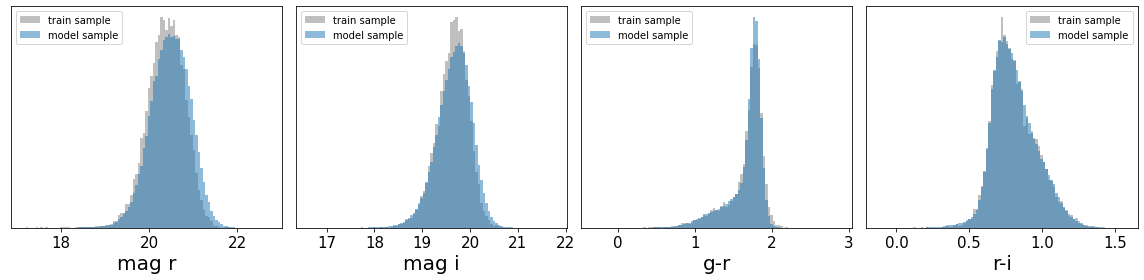

In [18]:
# Comparison. train vs. random sample from the fitted gaussian mixture model (visual)-- CMASS
doVisualization_1d( data=[X_sample_cmass, X_sample_cmass_warner], 
                   labels = ['mag r', 'mag i', 'g-r', 'r-i'], 
                   ranges = None, 
                   name = ['train sample', 'model sample'], 
                   weight = [None,None], 
                   nbins=100)

In [16]:
# Comparison. train vs. random sample from the fitted gaussian mixture model (visual)-- CMASS
doVisualization_1d( data=[X_sample_nocmass, X_sample_nocmass_su], 
                   labels = ['mag r', 'mag i', 'g-r', 'r-i'], 
                   ranges = None, 
                   name = ['train sample', 'model sample'], 
                   weight = [None,None], 
                   nbins=100, filename = 'suVnocmass.png')

Using central 100% to set range.


Using central 100% to set range.
writing output plot to: ..//spt_v3_diagnostic_histograms_1d.pdf


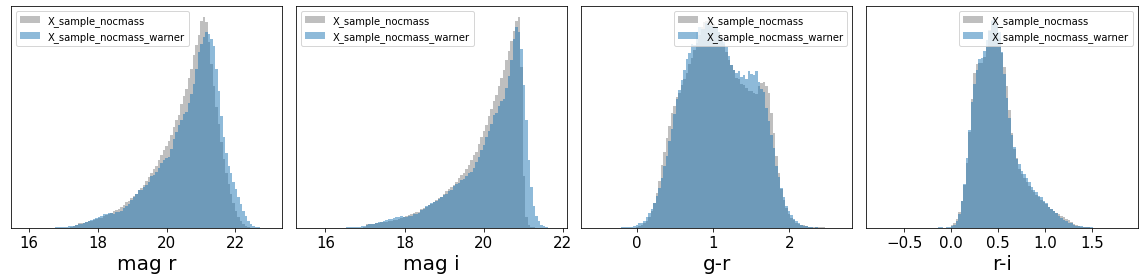

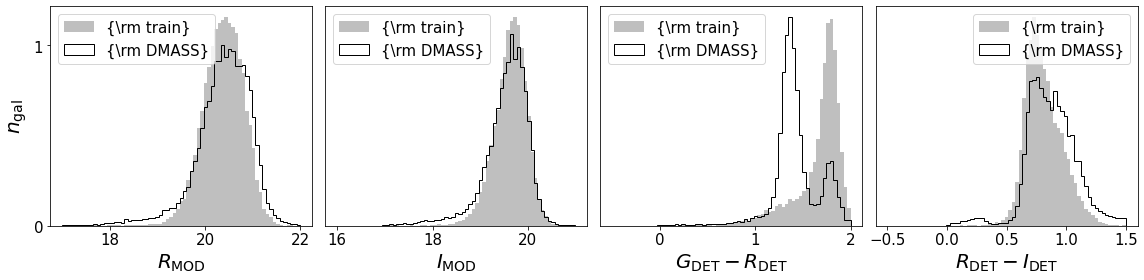

In [21]:
# Comparison. train vs. random sample from the fitted gaussian mixture model (visual)-- nonCMASS
#comparison of fitted function: trained versus fitted
doVisualization_1d( data=[X_sample_nocmass, X_sample_nocmass_warner], 
                   labels = ['mag r', 'mag i', 'g-r', 'r-i'], 
                   ranges = None, 
                   name = ['X_sample_nocmass', 'X_sample_nocmass_warner'], 
                   weight = [None,None], 
                   nbins=100)

#Figure 5: full histogram of dmass data

#CMASS distribution is correct: nonCMASS distribution is wrong--- need to fit nonCMASS distribution
X_train, Xcov_train = mixing_color(clean_cmass_data_des)
X_test,_ = mixing_color(dmass_spt)

weight = dmass_spt['CMASS_PROB']
# Plotting all
labels = [r'${R_{\rm MOD}}$', r'${I_{\rm MOD}}$', r'$G_{\rm DET}-R_{\rm DET}$', r'$R_{\rm DET}-I_{\rm DET}$']
ranges =  [[17,22], [16,21], [-.5,2], [-.5,1.5]]
hist_plot( X_train, X_test, labels = labels, ranges = ranges,\
                         name =[r'{\rm train}',r'{\rm DMASS}' ], nbins=70, \
                   weight=[None, weight], outdir = '../', prefix='spt_v3_')

#nonCMASS distribution problem for G-R panel--- sample size?

#second: computed cmass probab. based on bayesian stats. 
#line = (equation 15) total probab. of cmass and non
#gray = actual cmass data

In [41]:
import pickle
f = open(cmass_su_pickle, 'rb')
cmass_su = pickle.load(f, encoding="bytes")

In [42]:
f = open(cmass_pickle, 'rb')
cmass_warner = pickle.load(f, encoding="bytes")

In [46]:
cmass_su

{b'kwargs': {b'n_cl': None, b'init_params': None},
 b'args': (array([[20.69549942, 19.86739922,  1.74149895,  0.86300087,  0.39699936],
         [20.72130013, 19.92510033,  1.78319931,  0.83620071,  0.40659904],
         [20.81640053, 19.92749977,  1.7954998 ,  0.96399879,  0.43880081],
         ...,
         [20.29470062, 19.6826992 ,  1.167799  ,  0.65579987,  0.32999992],
         [20.3295002 , 19.60029984,  1.66820145,  0.79710007,  0.35919952],
         [20.32119942, 19.6678009 ,  1.9022007 ,  0.84259987,  0.42749977]]),
  array([[[ 1.18810000e-04,  0.00000000e+00,  0.00000000e+00,
            0.00000000e+00,  0.00000000e+00],
          [ 0.00000000e+00,  8.83600005e-05,  0.00000000e+00,
            0.00000000e+00,  0.00000000e+00],
          [ 0.00000000e+00,  0.00000000e+00,  1.94309012e-03,
           -9.40900063e-05,  0.00000000e+00],
          [ 0.00000000e+00,  0.00000000e+00, -9.40900063e-05,
            1.43090008e-04, -4.90000020e-05],
          [ 0.00000000e+00,  0.00000

In [47]:
cmass_warner

{'funcname': 'compute_XD',
 'retval': <xd.XDGMM at 0x2b35e981ab70>,
 'args': (array([[20.01748085, 19.24313354,  1.82705688,  0.77434731],
         [20.15995979, 19.26239777,  0.99136543,  0.89756203],
         [19.76826096, 19.24153328,  0.85228539,  0.52672768],
         ...,
         [20.52250481, 19.75559425,  1.76026154,  0.76691055],
         [20.67845917, 19.82345009,  1.89496613,  0.85500908],
         [20.74147987, 19.96460724,  1.78933907,  0.77687263]]),
  array([[[ 4.62400021e-05,  0.00000000e+00,  0.00000000e+00,
            0.00000000e+00],
          [ 0.00000000e+00,  2.80899985e-05,  0.00000000e+00,
            0.00000000e+00],
          [ 0.00000000e+00,  0.00000000e+00,  9.46239987e-04,
           -4.62400021e-05],
          [ 0.00000000e+00,  0.00000000e+00, -4.62400021e-05,
            7.43300006e-05]],
  
         [[ 8.46400071e-05,  0.00000000e+00,  0.00000000e+00,
            0.00000000e+00],
          [ 0.00000000e+00,  4.09599961e-05,  0.00000000e+00,
         

In [ ]:
help(XD_fitting_X)

In [20]:

def hist_plot( true, data1, labels = None, ranges = None, name = None, weight = [None,None], nbins=100, prefix= 'default', outdir='./'):


    if labels == None:
        print(" always label your axes! you must populate the 'labels' keyword with one entry for each dimension of the data.")
        stop
    else:
        ndim = len(labels)

    if ranges == None:
        # try to figure out the correct axis ranges.
        print("Using central 98% to set range.")
        ranges = []
        for i in range(ndim):
            ranges.append( np.percentile(real_data[:,i],[1.,99.]) )

    fig,axes = plt.subplots(nrows=1, ncols= ndim, figsize= (4*ndim, 4) )

    #print weight[0], weight[1].size, data1[:,0].size
    for i in range(ndim):
        xbins = np.linspace(ranges[i][0],ranges[i][1], nbins)
        axes[i].hist(true[:,i],bins=xbins, density= True, label=name[0], weights=weight[0], alpha = 0.5, color ='grey')
        Nhist, _, _=axes[i].hist(data1[:,i],bins=xbins, density = True, alpha=1.0,label=name[1], weights=weight[1], histtype='step', color='k', lw=1)
        axes[i].set_xlabel(labels[i], fontsize = 20)
        #axes[i].hist(data2[:,i],bins=xbins,normed=True,alpha=0.5,label='data2')
        if i == 0 :
            axes[i].set_yticks([0, Nhist.max()])
            axes[i].set_yticklabels(['$0$', '$1$'])
            axes[i].set_ylabel(r'$n_{\rm gal}$', fontsize=20)
        axes[i].get_yaxis().set_visible(False)
        axes[i].tick_params(labelsize=15)
        axes[i].legend(loc='best',fontsize = 15)

    axes[0].get_yaxis().set_visible(True)
    
    
    
    filename = outdir+"/"+prefix+"diagnostic_histograms_1d.pdf"
    print("writing output plot to: "+filename)
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.05, hspace=0.5);
    fig.savefig(filename)
    #plt.close(fig)

writing output plot to: ..//spt_v3_diagnostic_histograms_1d.pdf


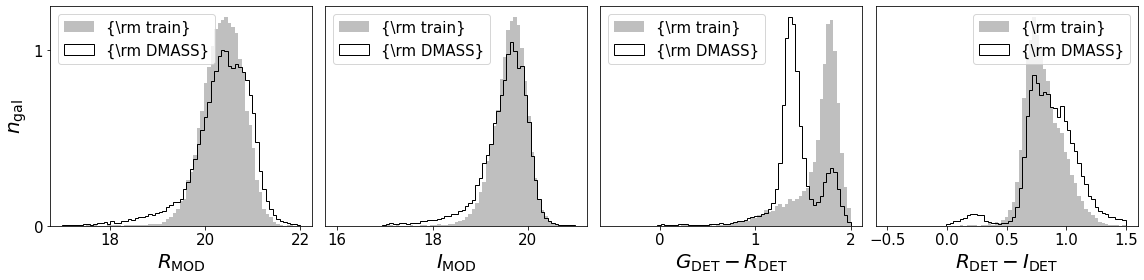

In [59]:
#Figure 5: full histogram of dmass data

#CMASS distribution is correct: nonCMASS distribution is wrong--- need to fit nonCMASS distribution
X_train, Xcov_train = mixing_color(clean_cmass_data_des)
X_test,_ = mixing_color(dmass_spt)

weight = dmass_spt['CMASS_PROB']
# Plotting all
labels = [r'${R_{\rm MOD}}$', r'${I_{\rm MOD}}$', r'$G_{\rm DET}-R_{\rm DET}$', r'$R_{\rm DET}-I_{\rm DET}$']
ranges =  [[17,22], [16,21], [-.5,2], [-.5,1.5]]
hist_plot( X_train, X_test, labels = labels, ranges = ranges,\
                         name =[r'{\rm train}',r'{\rm DMASS}' ], nbins=70, \
                   weight=[None, weight], outdir = '../', prefix='spt_v3_')

In [3]:
help(io.SearchAndCallFits)

Help on function SearchAndCallFits in module cmass_modules.io:

SearchAndCallFits(path=None, keyword=None, no_keyword=None, columns=None)



In [5]:
# catalogs without cuts applied:

##ST82 REGION catalog:

train_path = '/fs/scratch/PCON0003/warner785/bwarner/gold_cat/GOLD_STRIPE82/'
path =  train_path
train_keyword = 'Y1A1_GOLD_STRIPE82_v2'
    
columns = ['FLAGS_GOLD', 'FLAGS_BADREGION', 'MAG_MODEL_G', 'MAG_MODEL_R', 'MAG_MODEL_I', 'MAG_MODEL_Z',\
               'MAG_DETMODEL_G', 'MAG_DETMODEL_R', 'MAG_DETMODEL_I', 'MAG_DETMODEL_Z', 'MAGERR_DETMODEL_G',\
               'MAGERR_DETMODEL_R', 'MAGERR_DETMODEL_I', 'MAGERR_DETMODEL_Z', 'MAGERR_MODEL_G', 'MAGERR_MODEL_R',\
               'MAGERR_MODEL_I', 'MAGERR_MODEL_Z', 'MAG_AUTO_G', 'MAG_AUTO_R', 'MAG_AUTO_I', 'MAG_AUTO_Z', 'RA',\
               'DEC', 'COADD_OBJECTS_ID', 'MODEST_CLASS', 'HPIX', 'DESDM_ZP',\
               'SLR_SHIFT_G', 'SLR_SHIFT_R', 'SLR_SHIFT_I', 'SLR_SHIFT_Z', 'SLR_SHIFT_Y', 'EBV']

gold_st82_pure = io.SearchAndCallFits(path = train_path, columns = columns, keyword = train_keyword )
gold_st82_pure = gold_st82_pure[(gold_st82_pure['MODEST_CLASS'] == 1)&(gold_st82_pure['FLAGS_GOLD'] == 0 )]
print(gold_st82_pure.size)


Calling catalogs >>>
Y1A1_GOLD_STRIPE82_v2_000006.fits
Y1A1_GOLD_STRIPE82_v2_000005.fits
Y1A1_GOLD_STRIPE82_v2_000002.fits
Y1A1_GOLD_STRIPE82_v2_000008.fits
Y1A1_GOLD_STRIPE82_v2_000003.fits
Y1A1_GOLD_STRIPE82_v2_000001.fits
Y1A1_GOLD_STRIPE82_v2_000007.fits
Y1A1_GOLD_STRIPE82_v2_000004.fits
reading 1/8 /fs/scratch/PCON0003/warner785/bwarner/gold_cat/GOLD_STRIPE82/Y1A1_GOLD_STRIPE82_v2_000006.fits
reading 2/8 /fs/scratch/PCON0003/warner785/bwarner/gold_cat/GOLD_STRIPE82/Y1A1_GOLD_STRIPE82_v2_000005.fits
reading 3/8 /fs/scratch/PCON0003/warner785/bwarner/gold_cat/GOLD_STRIPE82/Y1A1_GOLD_STRIPE82_v2_000002.fits
reading 4/8 /fs/scratch/PCON0003/warner785/bwarner/gold_cat/GOLD_STRIPE82/Y1A1_GOLD_STRIPE82_v2_000008.fits
reading 5/8 /fs/scratch/PCON0003/warner785/bwarner/gold_cat/GOLD_STRIPE82/Y1A1_GOLD_STRIPE82_v2_000003.fits
reading 6/8 /fs/scratch/PCON0003/warner785/bwarner/gold_cat/GOLD_STRIPE82/Y1A1_GOLD_STRIPE82_v2_000001.fits
reading 7/8 /fs/scratch/PCON0003/warner785/bwarner/gold_ca

In [24]:
##SPT REGION catalog: (only part of)

input_path = '/fs/scratch/PCON0003/warner785/bwarner/gold_cat/'
input_keyword = 'Y1A1_GOLD_slr_ebv_00000'
columns = ['FLAGS_GOLD', 'FLAGS_BADREGION', 'MAG_MODEL_G', 'MAG_MODEL_R', 'MAG_MODEL_I', 'MAG_MODEL_Z',\
               'MAG_DETMODEL_G', 'MAG_DETMODEL_R', 'MAG_DETMODEL_I', 'MAG_DETMODEL_Z', 'MAGERR_DETMODEL_G',\
               'MAGERR_DETMODEL_R', 'MAGERR_DETMODEL_I', 'MAGERR_DETMODEL_Z', 'MAGERR_MODEL_G', 'MAGERR_MODEL_R',\
               'MAGERR_MODEL_I', 'MAGERR_MODEL_Z', 'MAG_AUTO_G', 'MAG_AUTO_R', 'MAG_AUTO_I', 'MAG_AUTO_Z', 'RA',\
               'DEC', 'COADD_OBJECTS_ID', 'MODEST_CLASS', 'HPIX', 'DESDM_ZP',\
               'SLR_SHIFT_G','SLR_SHIFT_R', 'SLR_SHIFT_I', 'SLR_SHIFT_Z','EBV']
gold_spt_pure = io.SearchAndCallFits(path = input_path, keyword = input_keyword, columns=columns)
gold_spt_pure = gold_spt_pure[(gold_spt_pure['MODEST_CLASS'] == 1)&(gold_spt_pure['FLAGS_GOLD'] == 0 )]

print(gold_spt_pure.size)


Calling catalogs >>>
Y1A1_GOLD_slr_ebv_000007.fits
Y1A1_GOLD_slr_ebv_000008.fits
Y1A1_GOLD_slr_ebv_000009.fits
Y1A1_GOLD_slr_ebv_000003.fits
Y1A1_GOLD_slr_ebv_000004.fits
Y1A1_GOLD_slr_ebv_000005.fits
Y1A1_GOLD_slr_ebv_000001.fits
Y1A1_GOLD_slr_ebv_000006.fits
Y1A1_GOLD_slr_ebv_000002.fits
reading 1/9 /fs/scratch/PCON0003/warner785/bwarner/gold_cat/Y1A1_GOLD_slr_ebv_000007.fits
reading 2/9 /fs/scratch/PCON0003/warner785/bwarner/gold_cat/Y1A1_GOLD_slr_ebv_000008.fits
reading 3/9 /fs/scratch/PCON0003/warner785/bwarner/gold_cat/Y1A1_GOLD_slr_ebv_000009.fits
reading 4/9 /fs/scratch/PCON0003/warner785/bwarner/gold_cat/Y1A1_GOLD_slr_ebv_000003.fits
reading 5/9 /fs/scratch/PCON0003/warner785/bwarner/gold_cat/Y1A1_GOLD_slr_ebv_000004.fits
reading 6/9 /fs/scratch/PCON0003/warner785/bwarner/gold_cat/Y1A1_GOLD_slr_ebv_000005.fits
reading 7/9 /fs/scratch/PCON0003/warner785/bwarner/gold_cat/Y1A1_GOLD_slr_ebv_000001.fits
reading 8/9 /fs/scratch/PCON0003/warner785/bwarner/gold_cat/Y1A1_GOLD_slr_ebv_

In [25]:
#takes 1 percent of spt sample:
print(gold_spt_pure.size)
gold_spt_random_ind = np.random.choice(np.arange(gold_spt_pure.size), size = int(gold_spt_pure.size/100))
gold_spt_random = gold_spt_pure[gold_spt_random_ind]
print(gold_spt_random.size)

58386848
583868


9050359
583868


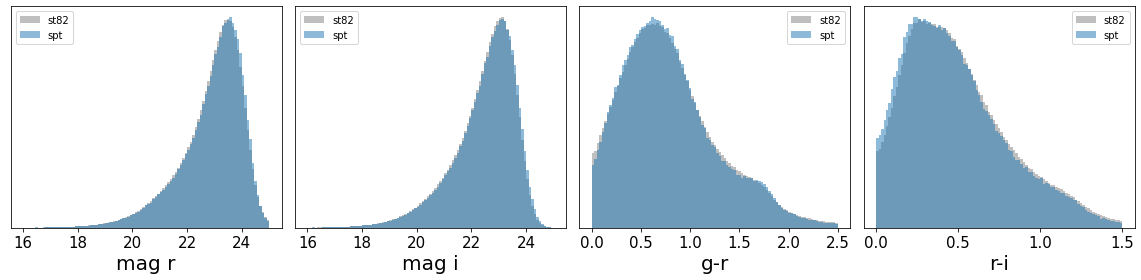

In [26]:
# compare pure gold fits files

print(gold_st82_pure.size)
print(gold_spt_random.size)

#des gold catalog probability distribution

X_train, Xcov_train = mixing_color(gold_st82_pure)
X_sample_st82 = X_train
X_train2, Xcov_train2 = mixing_color(gold_spt_random)
X_sample_spt = X_train2

# Comparison. st82 vs. spt sample from the fitted gaussian mixture model (visual)
# des gold galaxies: should be same because isotropic-- color cuts problem?
doVisualization_1d( data=[X_sample_st82, X_sample_spt], 
                   labels = ['mag r', 'mag i', 'g-r', 'r-i'], 
                   ranges = [[16, 25], [16, 25] , [0, 2.5] , [0, 1.5] ], 
                   name = ['st82', 'spt'], 
                   weight = [None,None], 
                   nbins=100, filename = 'pure.png')

In [14]:
# make plots for other colors
MAG_AUTO_i
gold_st82['MAG_AUTO_i']

#make plots for mag_griz (for mag_auto, mag_detmodel, mag_model), g-r, r-i, i-z
# make histogram of mag_auto